<a href="https://colab.research.google.com/github/SamudralaAjaykumarrr/AI-Data-Quality-Drift-Detector/blob/main/AI_Data_Quality_%26_Drift_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1
import numpy as np, pandas as pd, json, os
from scipy.stats import ks_2samp
os.makedirs("/content/data_quality_outputs", exist_ok=True)
np.random.seed(42)
print("Ready")


Ready


In [ ]:
# Cell 2
n = 1000
old = pd.DataFrame({
    "feature_a": np.random.normal(50,10,n),
    "feature_b": np.random.normal(100,20,n),
    "feature_c": np.random.uniform(0,1,n),
    "label": np.random.choice([0,1],n)
})
new = pd.DataFrame({
    "feature_a": np.random.normal(55,12,n),  # mean drift
    "feature_b": np.random.normal(90,22,n),  # mean shift
    "feature_c": np.random.uniform(0,1,n),
    "label": np.random.choice([0,1],n)
})
old.to_csv("/content/data_quality_outputs/old_data.csv", index=False)
new.to_csv("/content/data_quality_outputs/new_data.csv", index=False)
print("Saved sample datasets")


Saved sample datasets


In [ ]:
# Cell 3
def check_missing(df):
    return df.isnull().sum().to_dict()

def check_outliers(df):
    out = {}
    for c in df.select_dtypes(include='number').columns:
        q1,q3 = df[c].quantile([0.25,0.75])
        iqr = q3-q1
        low, high = q1-1.5*iqr, q3+1.5*iqr
        out[c] = int(((df[c]<low)|(df[c]>high)).sum())
    return out

def check_schema(a,b):
    return {
        "old_schema": a.dtypes.astype(str).to_dict(),
        "new_schema": b.dtypes.astype(str).to_dict(),
        "match": a.dtypes.equals(b.dtypes)
    }

def ks_drift(a,b):
    res = {}
    for c in a.select_dtypes(include='number').columns:
        stat, p = ks_2samp(a[c], b[c])
        res[c] = {"p_value": float(p), "drift": bool(p < 0.05)}
    return res


In [ ]:
# Cell 4
missing_new = check_missing(new)
outliers_new = check_outliers(new)
schemas = check_schema(old,new)
drift = ks_drift(old,new)

score = 100
score -= sum(missing_new.values())*0.1
score -= sum(outliers_new.values())*0.05
if not schemas["match"]: score -= 10
score -= sum(1 for v in drift.values() if v["drift"]) * 5
score = max(0, round(score,2))

report = {
    "missing_values": missing_new,
    "outliers": outliers_new,
    "schema": schemas,
    "drift": drift,
    "quality_score": score
}
with open("/content/data_quality_outputs/data_quality_report.json","w") as f:
    json.dump(report, f, indent=2)

print("Report saved to /content/data_quality_outputs/data_quality_report.json")
!ls -la /content/data_quality_outputs


Report saved to /content/data_quality_outputs/data_quality_report.json
total 132
drwxr-xr-x 2 root root  4096 Nov 16 15:35 .
drwxr-xr-x 1 root root  4096 Nov 16 15:34 ..
-rw-r--r-- 1 root root   899 Nov 16 15:35 data_quality_report.json
-rw-r--r-- 1 root root 57651 Nov 16 15:34 new_data.csv
-rw-r--r-- 1 root root 57882 Nov 16 15:34 old_data.csv


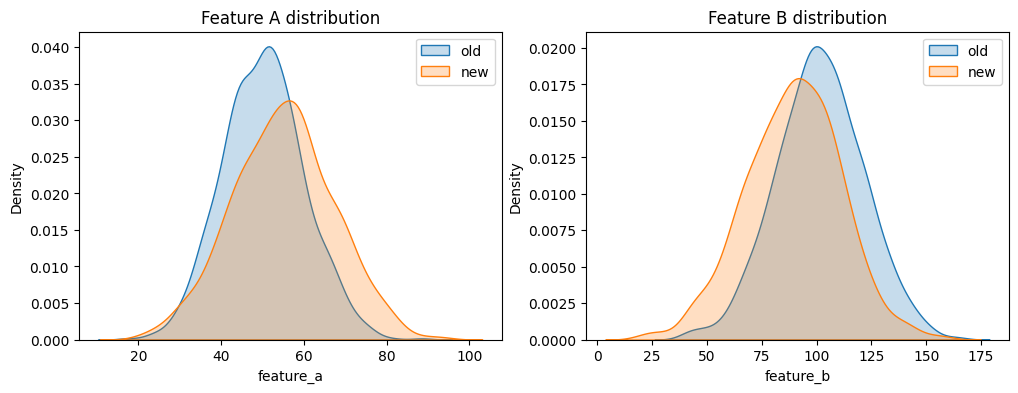

In [ ]:
# Cell 5
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(old['feature_a'], label='old', fill=True)
sns.kdeplot(new['feature_a'], label='new', fill=True)
plt.title("Feature A distribution")
plt.legend()
plt.subplot(1,2,2)
sns.kdeplot(old['feature_b'], label='old', fill=True)
sns.kdeplot(new['feature_b'], label='new', fill=True)
plt.title("Feature B distribution")
plt.legend()
plt.show()
